In [182]:
import wave
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # SVM classifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import sounddevice as sd
import soundfile as sf
#Test Commit


In [183]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq  # Normalize the lowcut frequency
    high = highcut / nyq  # Normalize the highcut frequency
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def low_pass_filter(data, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

def high_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

In [184]:
file_path = "data/esther-post.wav"
with wave.open(file_path, 'rb') as wav_file:
    num_channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    fs = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    duration = num_frames / fs

    frames = wav_file.readframes(num_frames)

def convert_to_mono(file_path):
    # Read the stereo audio file
    audio_data, sample_rate = sf.read(file_path)
    
    # Check if the audio data is stereo (2 channels)
    if audio_data.ndim > 1:
        # Average the two channels to create a mono signal
        audio_data = audio_data.mean(axis=1)

    return audio_data

print(num_channels)
audio_data = np.frombuffer(frames, dtype=np.int16)
audio_data = convert_to_mono(file_path)
print(f"Total number of elements in the array: {audio_data.size}")
time_axis = np.linspace(0, num_frames / fs, num=num_frames)
sf.write("AUDIO_TEST_DATa.wav", audio_data, fs)

start_time = 1.0  # Start at 1 second
end_time = 3.0    # End at 3 seconds
start_sample = int(start_time * fs)
end_sample = int(end_time * fs)
trimmed_audio = audio_data[start_sample:end_sample]
trimmed_time_axis = np.linspace(start_time, end_time, num=len(trimmed_audio))
#sf.write("audio_data_test.wav", audio_data, fs)

2
Total number of elements in the array: 1181952


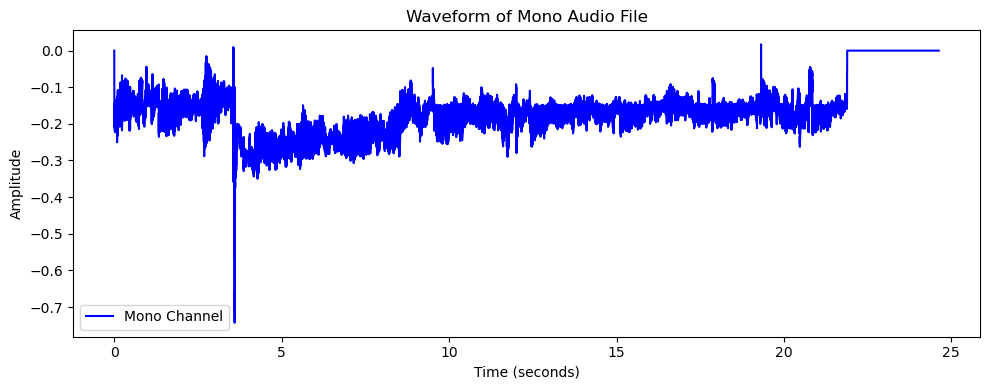

In [185]:
plt.figure(figsize=(10, 4))
plt.plot(time_axis, audio_data, label="Mono Channel", color="blue")
#plt.plot(trimmed_time_axis, trimmed_audio, label="Mono Channel", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of Mono Audio File")
plt.legend()
plt.tight_layout()
plt.show()

In [186]:
#Filtering Entire Data Sample
filtered_audio_data = high_pass_filter(audio_data, 7.5, fs, 1)
filtered_audio_data = low_pass_filter(filtered_audio_data, (fs/2)-100, fs, 8)
filtered_audio_data = bandpass_filter(filtered_audio_data, 80, 1600, fs, 4)
#sf.write("filtered_audio.wav", filtered_audio_data, fs)

#Filtering Trimmed Portion
trimmed_filtered_audio_data = filtered_audio_data[start_sample:end_sample]
trimmed_filtered_time_axis = np.linspace(start_time, end_time, num=len(filtered_audio_data))
#sf.write("trimmed_filtered_audio.wav", trimmed_filtered_audio_data, fs)

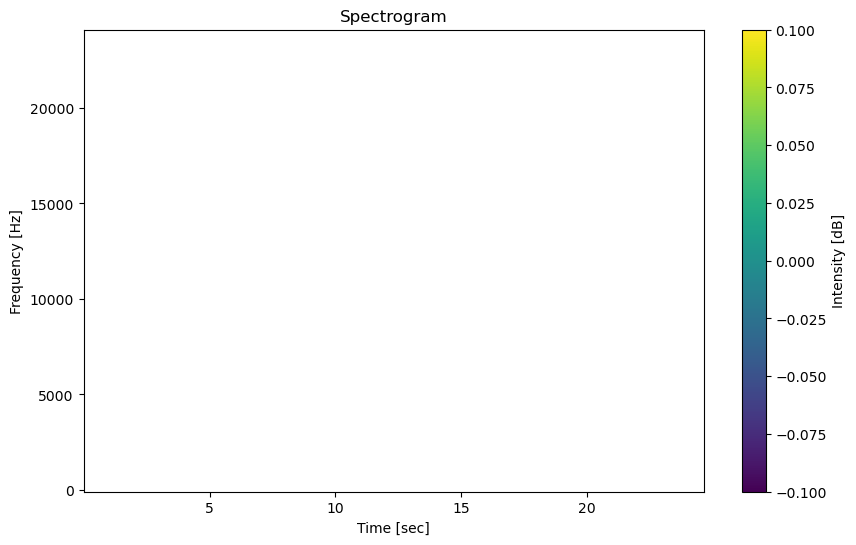

In [187]:
frequencies, times, Sxx = spectrogram(filtered_audio_data, fs)
# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')  # Convert to dB scale
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

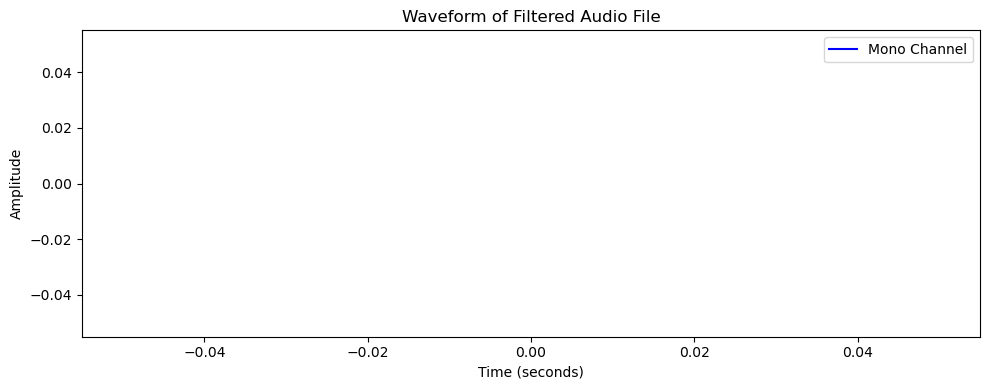

In [188]:
plt.figure(figsize=(10, 4))
plt.plot(time_axis, filtered_audio_data, label="Mono Channel", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of Filtered Audio File")
plt.legend()
plt.tight_layout()
plt.show()

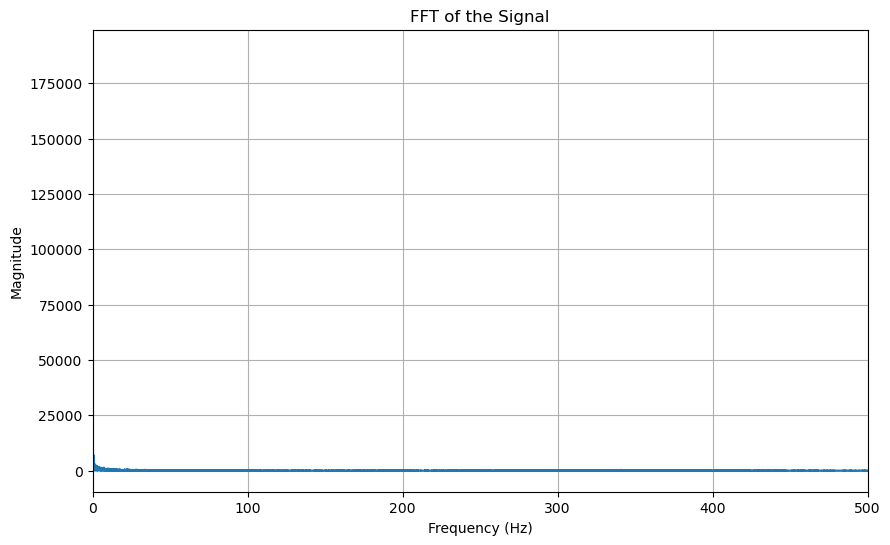

In [189]:
fft_values = np.fft.fft(audio_data)
fft_freq = np.fft.fftfreq(len(audio_data), 1/fs)  # Frequency values for the x-axis

# Take the magnitude of the FFT and plot
magnitude = np.abs(fft_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fft_freq[:len(fft_freq)//2], magnitude[:len(magnitude)//2])  # Only plot positive frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of the Signal')
plt.xlim(0, 500)
plt.grid()
plt.show()

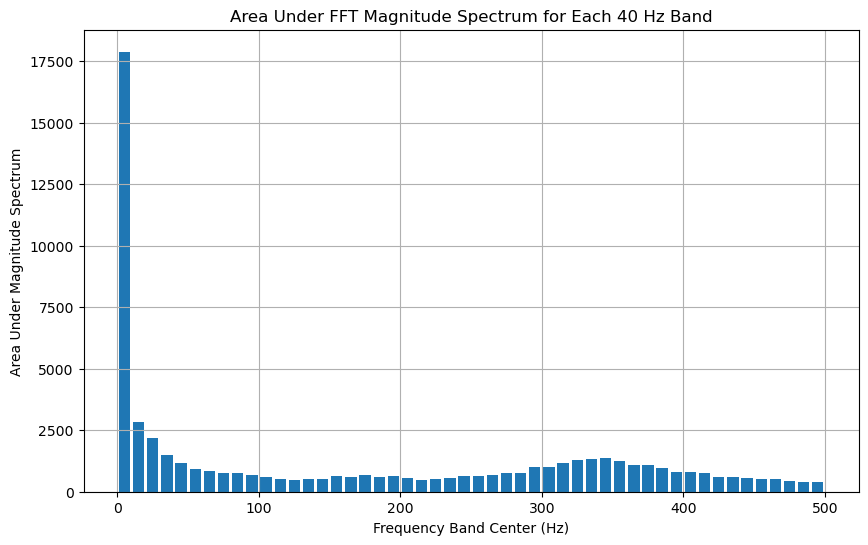

In [190]:
band_width = 10
max_freq = 500
num_bands = int(max_freq / band_width)
band_areas = []
band_centers = []

for i in range(num_bands):
    # Define band range
    band_start = i * band_width
    band_end = min((i + 1) * band_width, max_freq)
    
    # Mask to select frequency range within the band
    band_mask = (fft_freq >= band_start) & (fft_freq < band_end)
    
    # Calculate area under the magnitude within this band
    band_area = np.trapz(magnitude[band_mask], fft_freq[band_mask])
    band_areas.append(band_area)
    band_centers.append((band_start + band_end) / 2)  # Center frequency of the band

# Plot the area under each band
plt.figure(figsize=(10, 6))
plt.bar(band_centers, band_areas, width=band_width * 0.8, align='center')  # Adjust width for spacing
plt.xlabel('Frequency Band Center (Hz)')
plt.ylabel('Area Under Magnitude Spectrum')
plt.title('Area Under FFT Magnitude Spectrum for Each 40 Hz Band')
plt.grid()
plt.show()

In [191]:
df = pd.DataFrame(band_areas, columns=['Power'])
df = df.T; 
df['Label'] = "W"; 
df.head(50)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Label
Power,17885.918601,2838.115236,2165.440708,1509.61423,1172.717573,928.671359,834.54272,767.135658,742.088924,680.310147,...,743.686157,591.483708,613.38174,546.181567,527.263636,498.352675,444.636907,388.342716,387.412992,W


# ML WORK

In [192]:
#X = df.drop(columns='Label')
#y = df['Label']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

#model = SVC()
#model.fit(X_train, y_train)

#y_pred = model.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')